# 1. Circuit definition

In [3]:
%matplotlib inline
import numpy as np
from utils.gates import ONE_QUBIT_FIXED_GATE_SET, TWO_QUBITS_FIXED_GATE_SET, FIXED_GATE_SET, \
    ONE_QUBIT_PARAMETRISED_GATE_SET, TWO_QUBITS_PARAMETRISED_GATE_SET, PARAMETRISED_GATE_SET, \
    ONE_QUBIT_GATES, TWO_QUBITS_GATES, CircuitGate, GATES
from utils.states import State, STATES
from utils.circuit import Circuit

from utils.draw_circuit import draw_circuit, save_circuit_drawing
from utils.random_gates import sample_random_gates, resolve_parameters

np.set_printoptions(precision=3, suppress=True)

# define rng
RNG = np.random.default_rng(4242)

### STATES

In [4]:
print(STATES.psi_minus)
print(STATES.psi_minus.qubit_vector)

print(STATES.generate_zero_n_qubit_state(4))

print(STATES.generate_state([
    STATES.zero,
    STATES.psi_plus,
    STATES.phi_minus
]))

0.707 |01⟩ + -0.707 |10⟩
[[ 0.   +0.j]
 [ 0.707+0.j]
 [-0.707+0.j]
 [ 0.   +0.j]]
1 |0000⟩
0.5 |00100⟩ + -0.5 |00111⟩ + 0.5 |01000⟩ + -0.5 |01011⟩


### GATES

In [5]:
gates=[  # TODO explain layers
        [
            CircuitGate(GATES.X, target_qubit=2),
            CircuitGate(GATES.H, target_qubit=0)
        ],
    
        [
            CircuitGate(GATES.init_Rx(np.pi / 4), target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=0)
        ],

        [
            CircuitGate(GATES.CNOT, target_qubit=2, control_qubit=1),
            CircuitGate(GATES.init_CRz(np.pi / 4), target_qubit=2, control_qubit=0),
            CircuitGate(GATES.CRx, target_qubit=2, control_qubit=0),
        ]
    ]

In [6]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(3),
    gates=gates
)

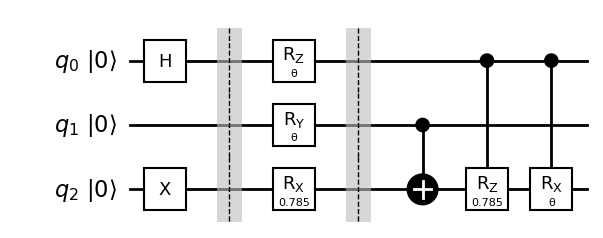

In [7]:
draw_circuit(gates, 3)

# NOISE

## (i) Depolarizing Noise

**What it is:**  
Depolarizing noise models **gate infidelities**. After the ideal gate, the affected qubit undergoes a Pauli channel that mixes in the maximally mixed state with small probability.

**When it affects:**  
- Applied **after each gate**.  
- For **1-qubit gates**: the channel acts on the operated qubit.  
- For **2-qubit gates**: the channel acts **only on the target qubit** (consistent with the asymmetric role of control vs. target in e.g. CNOT).

**Typical rates:**  
- 1-qubit gates: $p_{1}^{(1q)} \sim 10^{-3}$  
- 2-qubit gates: $p_{1}^{(2q)} \sim 5 \times 10^{-3}$  
- Often gate-dependent overrides are used (e.g. $p(\mathrm{CNOT}) \approx 0.02$).

**Mathematical representation:**  
For a density matrix $\rho$, the one-qubit depolarizing channel is
$$
\mathcal{E}_{\mathrm{depol}}(\rho)
= (1-p)\,\rho + \frac{p}{3}\Big(X\rho X + Y\rho Y + Z\rho Z\Big).
$$

- For a 1-qubit gate on qubit $q$, apply $\mathcal{E}_{\mathrm{depol}}$ to $q$.  
- For a 2-qubit gate $(c,t)$, apply $\mathcal{E}_{\mathrm{depol}}$ to the **target qubit $t$ only**.

**Kraus operators (for the affected qubit):**
$$
K_{0}=\sqrt{1-p}\,I,\qquad
K_{1}=\sqrt{\tfrac{p}{3}}\,X,\qquad
K_{2}=\sqrt{\tfrac{p}{3}}\,Y,\qquad
K_{3}=\sqrt{\tfrac{p}{3}}\,Z,
$$
so that
$$
\mathcal{E}_{\mathrm{depol}}(\rho)=\sum_{i=0}^3 K_i\,\rho\,K_i^\dagger.
$$


## (ii) SPAM Noise

**What it is:**  
SPAM (State Preparation And Measurement) noise models **imperfect initialization** and **readout errors**.  
- **Preparation error:** when preparing $|0\rangle$, a flip to $|1\rangle$ can occur with probability $p_2$.  
- **Measurement error:** when measuring, the outcome bit can be flipped with probability $p_2$.

**When it affects:**  
- At the **start** (state preparation).  
- At the **end** (measurement).

**Typical rates:**  
- Preparation errors: $\sim 10^{-3}$.  
- Measurement errors: $\sim 1\%\text{–}5\%$ (platform-dependent).

**Mathematical representation (Pauli-$X$ channel):**  
Kraus operators
$$
K_{M0}=\sqrt{1-p_2}\,I,\qquad K_{M1}=\sqrt{p_2}\,X,
$$
so that
$$
\mathcal{E}_{\mathrm{SPAM}}(\rho)=(1-p_2)\rho+p_2\,X\rho X.
$$


## (iii) TRC Noise (Thermal Relaxation + Dephasing)

**What it is:**  
The TRC channel models **amplitude damping** (energy relaxation, $T_1$) and **pure dephasing** ($T_2$). It captures relaxation toward $|0\rangle$ and loss of phase coherence over a **gate duration** $T_g$.

**When it affects:**  
- **After every gate** with finite duration $T_g$.  
- Acts **independently on each qubit** touched by the gate.  
- Low-temperature limit ($\Theta \approx 0$): excitations are negligible.

**Customary scales:**  
- $T_1, T_2$: tens of $\mu$s; $T_g$: ns–hundreds of ns.  
- Per-gate reset probability:
$$
p_{\mathrm{reset}} = 1 - e^{-T_g/T_1}.
$$
- Per-gate dephasing probability:
$$
p_Z = (1 - p_{\mathrm{reset}})
\,\frac{1 - \big(e^{-T_g/T_2}/e^{-T_g/T_1}\big)}{2}.
$$
Let $p_I = 1 - p_{\mathrm{reset}} - p_Z$.

**Channel form:**  
$$
\mathcal{E}_{\mathrm{TRC}}(\rho) = p_I\,\rho + p_Z\,Z\rho Z + p_{\mathrm{reset}}\,|0\rangle\langle 0| .
$$

**Kraus operators (low-$T$):**
$$
K_0=\begin{pmatrix}1&0\\[2pt]0&\sqrt{1-p_{\mathrm{reset}}}\end{pmatrix},\quad
K_1=\begin{pmatrix}0&\sqrt{p_{\mathrm{reset}}}\\[2pt]0&0\end{pmatrix},\quad
K_2=\sqrt{p_Z}\,Z.
$$


![Noise channels](images/noise_channels.png)
![Two qubit gates ](images/noise_channels_two_qubit_gates.png)


In [ ]:
# TODO result graphs!? compare noisy and normal? - also interactive graphs for noise!